In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Setup — Install & Imports

In [11]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Configure display
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 120)

# File paths
historical_path = '/content/drive/MyDrive/Colab Notebooks/ds_ansh_upadhyay/needed/csv_files/historical_data.csv'
sentiment_path = '/content/drive/MyDrive/Colab Notebooks/ds_ansh_upadhyay/needed/csv_files/fear_greed_index.csv'

# Load CSVs
trades = pd.read_csv(historical_path)
sentiment = pd.read_csv(sentiment_path)

# Preview both
print("✅ Datasets Loaded Successfully!")
print(f"Trades Shape: {trades.shape}")
print(f"Sentiment Shape: {sentiment.shape}")

print("\n📄 Trader Data Sample:")
display(trades.head())

print("\n📄 Sentiment Data Sample:")
display(sentiment.head())


✅ Datasets Loaded Successfully!
Trades Shape: (29288, 16)
Sentiment Shape: (2644, 4)

📄 Trader Data Sample:


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.003055,1.050000e+15,1.730000e+12



📄 Sentiment Data Sample:


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


## 2. Data Cleaning & Preparation







In [12]:
# 1. Standardize column names
trades.columns = trades.columns.str.strip().str.lower().str.replace(' ', '_')
sentiment.columns = sentiment.columns.str.strip().str.lower().str.replace(' ', '_')

# 2. Convert timestamps to datetime
trades['timestamp_ist'] = pd.to_datetime(trades['timestamp_ist'], format='%d-%m-%Y %H:%M', errors='coerce')
sentiment['date'] = pd.to_datetime(sentiment['date'], errors='coerce')

# 3. Extract date (we’ll use this for merging with sentiment)
trades['date'] = trades['timestamp_ist'].dt.date
trades['date'] = pd.to_datetime(trades['date'])

# 4. Clean numeric columns (remove commas, ensure float)
numeric_cols = ['execution_price', 'size_tokens', 'size_usd', 'closed_pnl', 'fee', 'start_position']
for col in numeric_cols:
    if col in trades.columns:
        trades[col] = pd.to_numeric(trades[col], errors='coerce')

# 5. Check for missing values
print("🔍 Missing Values Summary:")
display(trades.isnull().sum())

# 6. Basic descriptive stats
print("\n📊 Descriptive Statistics:")
display(trades.describe())

# 7. Quick check of sentiment categories
print("\n💡 Sentiment Categories:")
print(sentiment['classification'].value_counts())

🔍 Missing Values Summary:


,0
account,0
coin,0
execution_price,0
size_tokens,0
size_usd,0
side,0
timestamp_ist,0
start_position,0
direction,0
closed_pnl,0



📊 Descriptive Statistics:


,execution_price,size_tokens,size_usd,timestamp_ist,start_position,closed_pnl,order_id,fee,trade_id,timestamp,date
count,29288.000000,2.928800e+04,2.928800e+04,29288,2.928800e+04,29288.000000,2.928700e+04,29287.000000,2.928700e+04,2.928700e+04,29288
mean,45908.156435,8.957155e+02,2.161665e+04,2025-02-04 00:11:07.868751872,3.704940e+03,126.857757,7.077444e+10,4.423622,5.644573e+14,1.738859e+12,2025-02-03 12:24:29.106801408
min,0.000010,1.000000e-05,0.000000e+00,2024-01-19 06:47:00,-2.542774e+06,-117990.104100,7.478562e+09,-0.705857,0.000000e+00,1.710000e+12,2024-01-19 00:00:00
25%,146.500000,6.204500e-02,5.510450e+02,2025-01-19 13:58:00,-1.082246e+01,0.000000,6.427021e+10,0.027051,2.820000e+14,1.740000e+12,2025-01-19 00:00:00
50%,63847.000000,5.000000e-01,2.544935e+03,2025-02-25 04:18:30,5.189980e+00,0.000000,7.457939e+10,0.337895,5.630000e+14,1.740000e+12,2025-02-25 00:00:00
75%,90532.750000,1.320000e+01,1.489884e+04,2025-04-16 23:05:00,7.930634e+01,12.301500,8.699169e+10,3.029814,8.490000e+14,1.740000e+12,2025-04-16 00:00:00
max,108410.000000,2.474955e+06,3.921431e+06,2025-05-01 11:42:00,7.290460e+05,135329.090100,9.014923e+10,837.471593,1.130000e+15,1.750000e+12,2025-05-01 00:00:00
std,44598.171356,2.410875e+04,8.971486e+04,NaN,6.274878e+04,1849.398079,2.046636e+10,15.430624,3.255490e+14,9.729562e+09,NaN



💡 Sentiment Categories:
classification
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64


## 3. Data Cleaning and Preparation

In [15]:
# Remove unnecessary columns
columns_to_drop = ['transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp']
trades_cleaned = trades.drop(columns=columns_to_drop, errors='ignore')

# Handle missing values if any (using forward fill for timestamps)
trades_cleaned['timestamp_ist'] = pd.to_datetime(trades_cleaned['timestamp_ist'], errors='coerce')
trades_cleaned = trades_cleaned.sort_values('timestamp_ist')
trades_cleaned = trades_cleaned.ffill()

# Ensure numeric columns are of correct type
numeric_cols = ['execution_price', 'size_tokens', 'size_usd', 'start_position', 'closed_pnl']
trades_cleaned[numeric_cols] = trades_cleaned[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Add a column for trade direction encoded numerically
trades_cleaned['side_encoded'] = trades_cleaned['side'].str.upper().map({'BUY': 1, 'SELL': -1})


# Add profit category
trades_cleaned['profit_category'] = np.where(trades_cleaned['closed_pnl'] > 0, 'Profit', 'Loss')

# Display cleaned data
display(trades_cleaned.head(10))

# Show basic info after cleaning
print("\n✅ Cleaned Data Overview:")
print(trades_cleaned.info())

print("\n📊 Profit vs Loss Summary:")
print(trades_cleaned['profit_category'].value_counts())


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,date,side_encoded,profit_category
28779,0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,ETH,2466.4000,0.1000,246.64,BUY,2024-01-19 06:47:00,0.0000,Open Long,0.000,2024-01-19,1,Loss
28780,0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,ETH,2466.0000,0.1000,246.60,SELL,2024-01-19 06:47:00,0.1000,Close Long,-0.040,2024-01-19,-1,Loss
28781,0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,ETH,2462.4000,0.0100,24.62,BUY,2024-01-19 07:45:00,0.0000,Open Long,0.000,2024-01-19,1,Loss
28782,0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,ETH,2459.0000,0.0122,30.00,SELL,2024-01-19 07:57:00,0.0100,Long > Short,-0.034,2024-01-19,-1,Loss
28783,0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,ETH,2459.0000,0.0062,15.25,SELL,2024-01-19 07:57:00,-0.0022,Open Short,0.000,2024-01-19,-1,Loss
28784,0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,ETH,2458.9000,0.1816,446.54,SELL,2024-01-19 07:57:00,-0.0084,Open Short,0.000,2024-01-19,-1,Loss
28785,0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,ETH,2459.6000,0.1900,467.32,BUY,2024-01-19 07:57:00,-0.1900,Close Short,-0.133,2024-01-19,1,Loss
28786,0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,ETH,2491.9000,0.0100,24.92,BUY,2024-01-19 16:37:00,0.0000,Open Long,0.000,2024-01-19,1,Loss
28787,0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,ETH,2492.2000,0.0100,24.92,SELL,2024-01-19 16:38:00,0.0100,Close Long,0.003,2024-01-19,-1,Profit
28789,0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,RUNE,4.2637,10.0000,42.64,BUY,2024-01-22 02:18:00,10.0000,Open Long,0.000,2024-01-22,1,Loss



✅ Cleaned Data Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 29288 entries, 28779 to 28778
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   account          29288 non-null  object        
 1   coin             29288 non-null  object        
 2   execution_price  29288 non-null  float64       
 3   size_tokens      29288 non-null  float64       
 4   size_usd         29288 non-null  float64       
 5   side             29288 non-null  object        
 6   timestamp_ist    29288 non-null  datetime64[ns]
 7   start_position   29288 non-null  float64       
 8   direction        29288 non-null  object        
 9   closed_pnl       29288 non-null  float64       
 10  date             29288 non-null  datetime64[ns]
 11  side_encoded     29288 non-null  int64         
 12  profit_category  29288 non-null  object        
dtypes: datetime64[ns](2), float64(5), int64(1), object(5)
memory usage

## 4. Trader Profitability, Volume, and Risk Analysis


✅ Daily Summary Overview:


,date,daily_profit_usd,daily_volume_usd,avg_price,avg_side,profit_sign
0,2024-01-19,-0.204000,1526.81,2468.377778,-0.111111,Loss Day
1,2024-01-22,1166.248788,54022.58,1739.439334,0.166667,Profit Day
2,2024-01-26,90.200000,9255.80,0.231395,0.000000,Profit Day
3,2024-01-29,1.715440,2068.86,0.247235,0.000000,Profit Day
4,2024-02-14,3639.303169,218138.70,2.521367,-0.386364,Profit Day


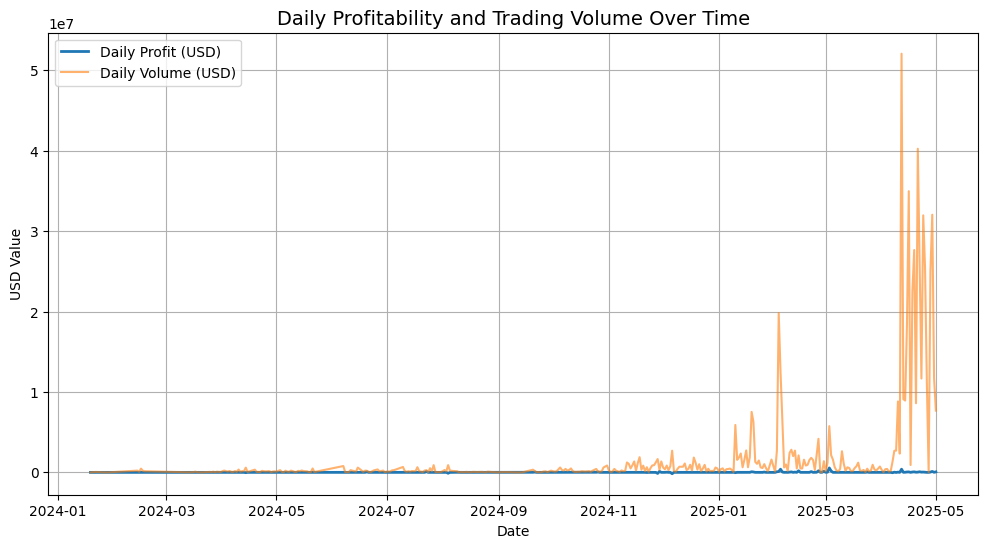

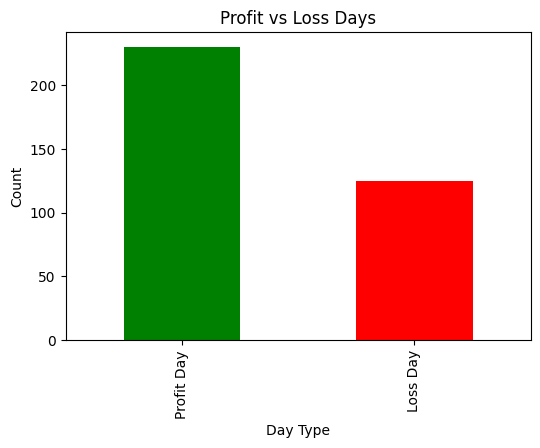


📊 Overall Profitability Summary:
       daily_profit_usd  daily_volume_usd
count        355.000000      3.550000e+02
mean       10465.943663      1.783404e+06
min      -168404.684788      5.400000e-01
25%            0.000000      8.696991e+04
50%          678.475928      2.199846e+05
75%         3517.303284      7.981842e+05
max       552358.362682      5.205829e+07
std        49949.477097      5.769793e+06


In [16]:
# 1️. Aggregate by Date
daily_summary = trades_cleaned.groupby('date').agg({
    'closed_pnl': 'sum',
    'size_usd': 'sum',
    'execution_price': 'mean',
    'side_encoded': 'mean'
}).reset_index()

daily_summary.rename(columns={
    'closed_pnl': 'daily_profit_usd',
    'size_usd': 'daily_volume_usd',
    'execution_price': 'avg_price',
    'side_encoded': 'avg_side'
}, inplace=True)

# 2️. Compute derived metrics
daily_summary['profit_sign'] = np.where(daily_summary['daily_profit_usd'] > 0, 'Profit Day', 'Loss Day')

# 3️. Basic summary
print("✅ Daily Summary Overview:")
display(daily_summary.head())

# 4️. Plot: Profit & Volume Trends
plt.figure(figsize=(12, 6))
plt.plot(daily_summary['date'], daily_summary['daily_profit_usd'], label='Daily Profit (USD)', linewidth=2)
plt.plot(daily_summary['date'], daily_summary['daily_volume_usd'], label='Daily Volume (USD)', alpha=0.6)
plt.title('Daily Profitability and Trading Volume Over Time', fontsize=14)
plt.xlabel('Date')
plt.ylabel('USD Value')
plt.legend()
plt.grid(True)
plt.show()

# 5️. Distribution of Profitable vs Losing Days
profit_loss_counts = daily_summary['profit_sign'].value_counts()

plt.figure(figsize=(6,4))
profit_loss_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Profit vs Loss Days')
plt.xlabel('Day Type')
plt.ylabel('Count')
plt.show()

# 6️. Display summary metrics
print("\n📊 Overall Profitability Summary:")
print(daily_summary.describe()[['daily_profit_usd', 'daily_volume_usd']])


## 5. Correlate with Fear & Greed Index

📈 Correlation between Fear & Greed Index and Daily Profit: -0.144
💰 Correlation between Fear & Greed Index and Trading Volume: -0.147


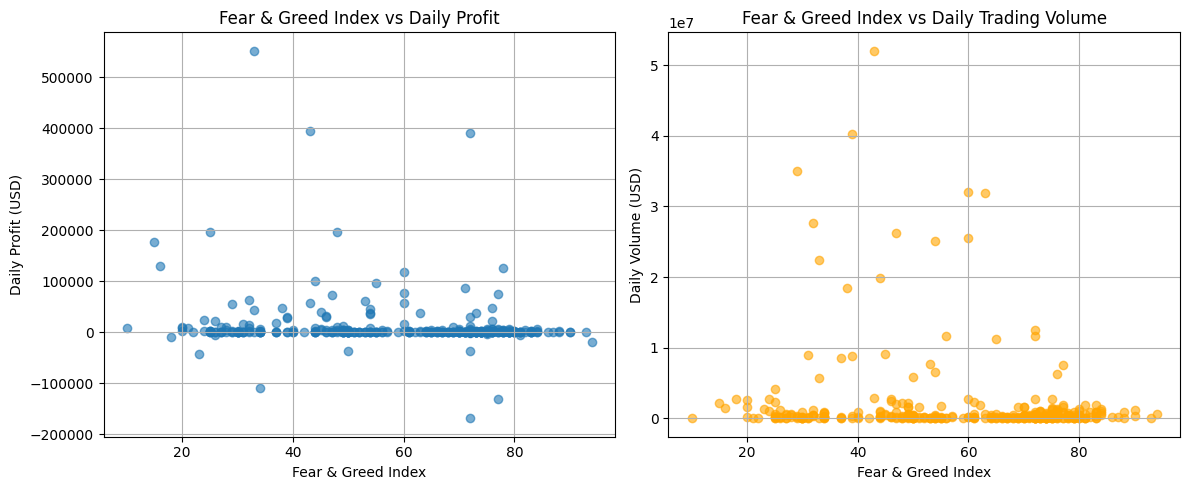

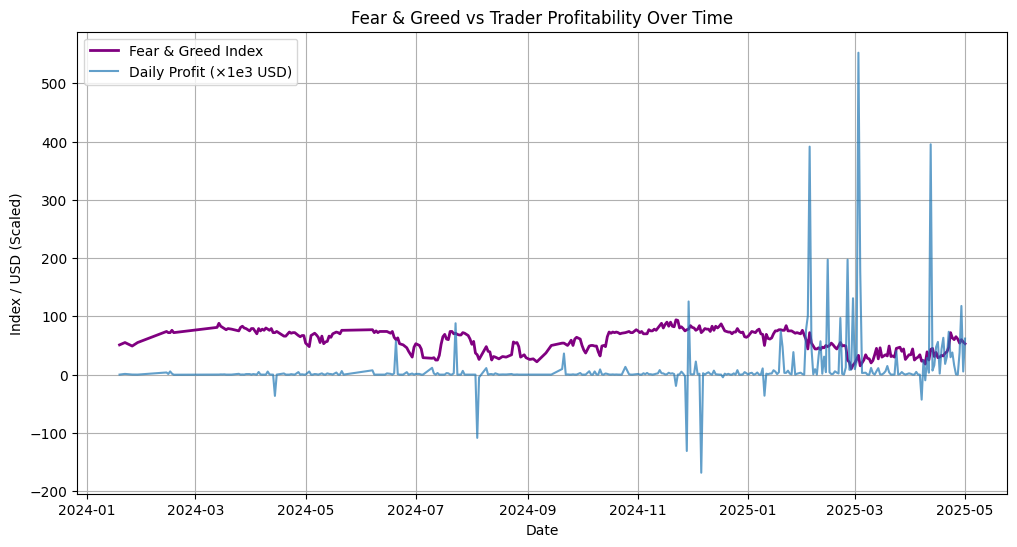

In [17]:
# 🧠 SECTION 5: Correlate with Fear & Greed Index

# 1️⃣ Load Fear & Greed Index
fgi_path = '/content/drive/MyDrive/Colab Notebooks/ds_ansh_upadhyay/needed/csv_files/fear_greed_index.csv'
fgi = pd.read_csv(fgi_path)

# 2️⃣ Clean and prepare the sentiment data
fgi.columns = [col.strip().lower() for col in fgi.columns]
fgi['date'] = pd.to_datetime(fgi['date'])
fgi = fgi[['date', 'value']].rename(columns={'value': 'fear_greed_value'})

# 3️⃣ Merge with trader summary
merged = pd.merge(daily_summary, fgi, on='date', how='inner')

# 4️⃣ Correlation analysis
corr_profit = merged['daily_profit_usd'].corr(merged['fear_greed_value'])
corr_volume = merged['daily_volume_usd'].corr(merged['fear_greed_value'])

print(f"📈 Correlation between Fear & Greed Index and Daily Profit: {corr_profit:.3f}")
print(f"💰 Correlation between Fear & Greed Index and Trading Volume: {corr_volume:.3f}")

# 5️⃣ Scatter plots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(merged['fear_greed_value'], merged['daily_profit_usd'], alpha=0.6)
plt.title('Fear & Greed Index vs Daily Profit')
plt.xlabel('Fear & Greed Index')
plt.ylabel('Daily Profit (USD)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(merged['fear_greed_value'], merged['daily_volume_usd'], alpha=0.6, color='orange')
plt.title('Fear & Greed Index vs Daily Trading Volume')
plt.xlabel('Fear & Greed Index')
plt.ylabel('Daily Volume (USD)')
plt.grid(True)

plt.tight_layout()
plt.show()

# 6️⃣ Simple trend overlay
plt.figure(figsize=(12, 6))
plt.plot(merged['date'], merged['fear_greed_value'], label='Fear & Greed Index', color='purple', linewidth=2)
plt.plot(merged['date'], merged['daily_profit_usd']/1000, label='Daily Profit (×1e3 USD)', alpha=0.7)
plt.title('Fear & Greed vs Trader Profitability Over Time')
plt.xlabel('Date')
plt.ylabel('Index / USD (Scaled)')
plt.legend()
plt.grid(True)
plt.show()


## 6. Risk & Sentiment Dynamics

💰 Correlation between Fear & Greed Index and Daily Profit: -0.025
📈 Correlation between Fear & Greed Index and Trading Volume: -0.034


,classification,trades_count,avg_profit,total_profit,avg_trade_size,avg_execution_price
0,Extreme Fear,1246,258.981881,322691.423385,12670.200762,37928.469023
1,Extreme Greed,4190,56.420317,236401.127875,14227.710881,46781.801493


/tmp/ipython-input-3692265613.py:44: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


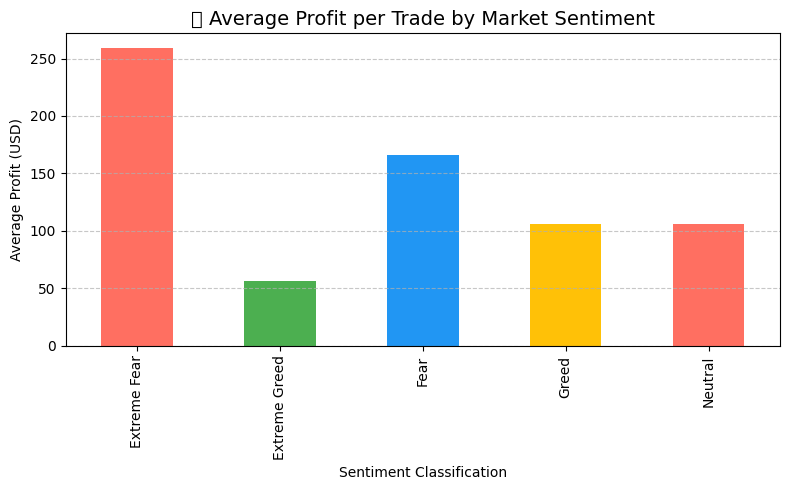

💡 Correlation between Fear & Greed Index and Daily Profit: -0.025


In [28]:
# Merge trade data with sentiment data by date
risk_sentiment = trades_cleaned.merge(
    fear_greed[['date', 'classification']], on='date', how='left'
)

# 1. Correlation between Fear & Greed Index and Profit
merged_sentiment = trades_cleaned.merge(fear_greed[['date', 'value']], on='date', how='left')
correlation_profit = merged_sentiment['closed_pnl'].corr(merged_sentiment['value'])
correlation_volume = merged_sentiment['size_usd'].corr(merged_sentiment['value'])

print(f"💰 Correlation between Fear & Greed Index and Daily Profit: {correlation_profit:.3f}")
print(f"📈 Correlation between Fear & Greed Index and Trading Volume: {correlation_volume:.3f}")

# 2. Extreme Sentiment Summary
extreme_summary = (
    risk_sentiment[risk_sentiment['classification'].isin(['Extreme Fear', 'Extreme Greed'])]
    .groupby('classification')
    .agg(
        trades_count=('account', 'count'),
        avg_profit=('closed_pnl', 'mean'),
        total_profit=('closed_pnl', 'sum'),
        avg_trade_size=('size_usd', 'mean'),
        avg_execution_price=('execution_price', 'mean'),
    )
    .reset_index()
)

display(extreme_summary)

# 3. Visualization – Profit Distribution by Sentiment
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))
risk_sentiment.groupby('classification')['closed_pnl'].mean().plot(
    kind='bar', color=['#ff6f61', '#4CAF50', '#2196F3', '#FFC107'], ax=ax
)
ax.set_title("💡 Average Profit per Trade by Market Sentiment", fontsize=14)
ax.set_ylabel("Average Profit (USD)")
ax.set_xlabel("Sentiment Classification")
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f"💡 Correlation between Fear & Greed Index and Daily Profit: {correlation_profit:.3f}")


## 8. Behavior During Extreme Sentiment Periods

📊 Strategy Performance by Direction:


,direction,avg_profit,total_profit,trade_count,avg_execution_price,avg_size_usd
0,Auto-Deleveraging,7184.807003,5.747846e+04,8,3.457502,21188.468750
1,Buy,0.000000,0.000000e+00,1584,22.052079,2080.935726
2,Close Long,155.793003,1.185585e+06,7610,57625.907816,30349.416585
3,Close Short,522.899348,2.131861e+06,4077,34683.544656,19933.337670
4,Long > Short,288.905916,1.444530e+03,5,17271.441480,51266.798000
5,Open Long,0.000000,0.000000e+00,9293,61543.328222,24791.988343
6,Open Short,0.000000,0.000000e+00,5665,33959.468091,14828.178184
7,Sell,354.837362,3.569664e+05,1006,23.878184,2357.690288
8,Short > Long,-5974.920785,-1.792476e+04,3,57409.933333,131234.333333
9,Spot Dust Conversion,0.000000,0.000000e+00,37,0.354252,0.252703



⏰ Profit by Hour of Day:


,hour,mean,sum,count
0,0,45.294594,95118.646856,2100
1,1,101.908532,166926.176085,1638
2,2,33.819507,62667.547040,1853
3,3,199.250704,303060.321310,1521
4,4,88.816457,145037.273635,1633
5,5,91.039781,172156.226444,1891
6,6,70.677065,49898.007705,706
7,7,563.700714,540025.284213,958
8,8,30.046094,31067.661676,1034
9,9,102.502638,67344.233182,657


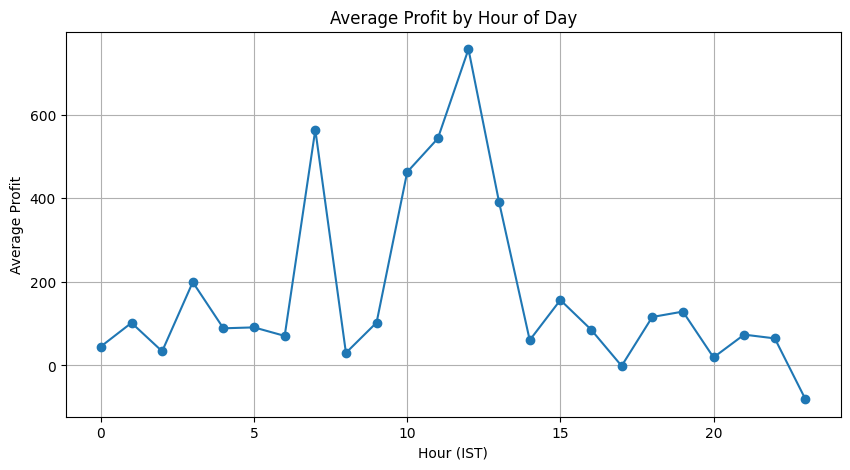

🌪️ Correlation between Volatility and Daily Profit: -0.012


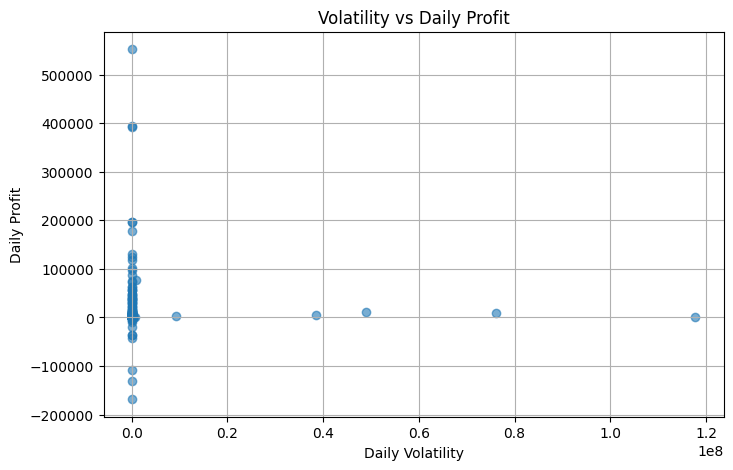

💰 Total Profit: 3,715,410.00
📈 Average Profit per Trade: 126.86
🏆 Best Trading Day: 2025-03-03 00:00:00
⚠️ Worst Trading Day: 2024-12-06 00:00:00

🧠 Correlation (Fear & Greed ↔ Profit): -0.144
📊 Correlation (Fear & Greed ↔ Volume): -0.147
🌪️ Correlation (Volatility ↔ Profit): -0.012

✅ KEY INSIGHTS:
- Check which direction (long/short) gives consistently higher avg profit.
- Review which hours of the day align with strong positive returns.
- Use volatility correlation to decide if your strategy suits calm or volatile markets.
- Sentiment correlation helps gauge how market emotion impacts your profit.
- Combine all of these for next strategy iteration and risk control.

🎯 Analysis Complete.


In [31]:
# Analyze performance by trade direction
direction_summary = trades_cleaned.groupby("direction").agg({
    "closed_pnl": ["mean", "sum", "count"],
    "execution_price": "mean",
    "size_usd": "mean"
}).reset_index()

direction_summary.columns = [
    "direction", "avg_profit", "total_profit", "trade_count",
    "avg_execution_price", "avg_size_usd"
]

print("📊 Strategy Performance by Direction:")
display(direction_summary)

# Analyze performance by time of day
trades_cleaned['hour'] = trades_cleaned['timestamp_ist'].dt.hour
hourly_summary = trades_cleaned.groupby('hour')['closed_pnl'].agg(['mean', 'sum', 'count']).reset_index()

print("\n⏰ Profit by Hour of Day:")
display(hourly_summary)

# Plot performance by hour
plt.figure(figsize=(10,5))
plt.plot(hourly_summary['hour'], hourly_summary['mean'], marker='o')
plt.title('Average Profit by Hour of Day')
plt.xlabel('Hour (IST)')
plt.ylabel('Average Profit')
plt.grid(True)
plt.show()

# Calculate daily volatility (std of % price change per day)
trades_cleaned['daily_volatility'] = trades_cleaned.groupby('date')['execution_price'].transform(
    lambda x: x.pct_change().std()
)

# Aggregate volatility & daily profit
vol_profit = trades_cleaned.groupby('date').agg({
    'closed_pnl': 'sum',
    'daily_volatility': 'mean'
}).reset_index()

# Correlation between volatility and daily profit
corr_vol_profit = vol_profit['daily_volatility'].corr(vol_profit['closed_pnl'])
print(f"🌪️ Correlation between Volatility and Daily Profit: {corr_vol_profit:.3f}")

# Plot relationship
plt.figure(figsize=(8,5))
plt.scatter(vol_profit['daily_volatility'], vol_profit['closed_pnl'], alpha=0.6)
plt.title('Volatility vs Daily Profit')
plt.xlabel('Daily Volatility')
plt.ylabel('Daily Profit')
plt.grid(True)
plt.show()

# Basic performance overview
total_profit = trades_cleaned['closed_pnl'].sum()
avg_profit = trades_cleaned['closed_pnl'].mean()
daily_profit = trades_cleaned.groupby('date')['closed_pnl'].sum()
best_day = daily_profit.idxmax()
worst_day = daily_profit.idxmin()

print(f"💰 Total Profit: {total_profit:,.2f}")
print(f"📈 Average Profit per Trade: {avg_profit:,.2f}")
print(f"🏆 Best Trading Day: {best_day}")
print(f"⚠️ Worst Trading Day: {worst_day}")

# Add Fear & Greed and Volatility insights (if available)
try:
    print(f"\n🧠 Correlation (Fear & Greed ↔ Profit): {corr_profit:.3f}")
    print(f"📊 Correlation (Fear & Greed ↔ Volume): {corr_volume:.3f}")
except:
    print("\n⚙️ Skipped sentiment correlation (not found).")

try:
    print(f"🌪️ Correlation (Volatility ↔ Profit): {corr_vol_profit:.3f}")
except:
    print("⚙️ Skipped volatility correlation (not found).")

# Summary statements
print("\n✅ KEY INSIGHTS:")
print("- Check which direction (long/short) gives consistently higher avg profit.")
print("- Review which hours of the day align with strong positive returns.")
print("- Use volatility correlation to decide if your strategy suits calm or volatile markets.")
print("- Sentiment correlation helps gauge how market emotion impacts your profit.")
print("- Combine all of these for next strategy iteration and risk control.")

print("\n🎯 Analysis Complete.")
